In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import minimize

In [2]:
aapl = pd.read_csv('AAPL.csv', index_col='Date', parse_dates=True)

In [3]:
aapl = aapl.drop(['Open', 'High','Low','Close','Volume'], axis=1)

In [4]:
amzn = pd.read_csv('AMZN.csv', index_col='Date', parse_dates=True)

In [5]:
amzn = amzn.drop(['Open', 'High','Low','Close','Volume'], axis=1)

In [8]:
stocks=pd.concat([aapl,amzn], axis=1)

In [9]:
stocks.columns = ['aapl','amzn']

In [10]:
stocks

,aapl,amzn
Date,,
2016-11-10,25.365192,742.380005
2016-11-11,25.515797,739.010010
2016-11-14,24.875729,719.070007
2016-11-15,25.205173,743.239990
2016-11-16,25.882893,746.489990
...,...,...
2021-11-03,151.269241,3384.000000
2021-11-04,150.740005,3477.000000
2021-11-05,151.279999,3518.989990


In [11]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret

,aapl,amzn
Date,,
2016-11-10,NaN,NaN
2016-11-11,0.005920,-0.004550
2016-11-14,-0.025405,-0.027353
2016-11-15,0.013157,0.033060
2016-11-16,0.026533,0.004363
...,...,...
2021-11-03,0.009751,0.021280
2021-11-04,-0.003505,0.027111
2021-11-05,0.003576,0.012004


In [13]:

np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(2))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]


In [14]:
print("Max sharpe ratio in the array : {}".format(sharpe_arr.max()))
print("Its location in the array : {}".format(sharpe_arr.argmax()))


Max sharpe ratio in the array : 1.255268407363444
Its location in the array : 2696


In [15]:
print(all_weights[5597,:])

max_sr_ret = ret_arr[sharpe_arr.argmax()]

max_sr_vol = vol_arr[sharpe_arr.argmax()]

[0.32594413 0.67405587]


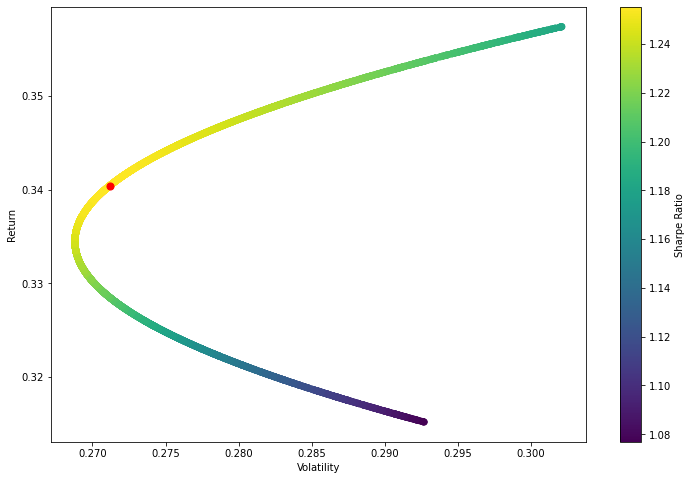

In [16]:

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()


In [17]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [20]:
cons = ({'type':'eq','fun':check_sum})
bounds = ((0,1),(0,1))
init_guess = [0.25,0.25]

In [21]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_results)

     fun: -1.2552684079577283
     jac: array([-1.25318766e-05,  1.86860561e-05])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.59808593, 0.40191407])


In [22]:
get_ret_vol_sr(opt_results.x)

array([0.34042338, 0.27119569, 1.25526841])

In [35]:
frontier_y = np.linspace(0.31,0.36,200)

In [36]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [37]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

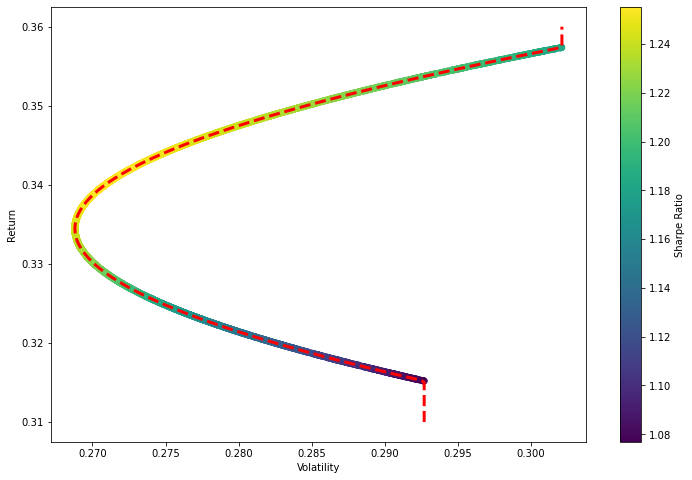

In [38]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.savefig('cover.png')
plt.show()